In [2]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import shutil
import nibabel as nib
import pydicom as dicomio 
import torch
import torch.optim as optim
import time

# 让 matplotlib 图表直接在 Jupyter 中显示
%matplotlib inline 

# 导入本地模块
try:
    from loss import TverskyLoss, MixedLoss
    from net import UNet_2D, UNet_3D
    from volume_patch_composer import volume_composer, patch_creator
    from dataset import Pancreas_2D_dataset, Pancreas_3D_dataset, partitioning
    from metrics import performance_metrics
    from train import train_2D, train_3D
    from inference import get_inference_performance_metrics_3D
except ImportError as e:
    print(f"❌ 错误: 缺少必要的模块文件 (如 net.py, loss.py)。\n详细信息: {e}")

print("库导入完成。")

库导入完成。


In [14]:
# ================= ⚙️ 配置区域 =================
CONFIG = {
    'raw_ct_dir': 'Pancreas-CT',              
    'raw_label_dir': 'Pancreas-CT-Label',     
    'processed_2d_dir': './data',               
    'processed_3d_dir': './data3D',             
    
    'unet_2d': False,              
    'batch_size': 96,                
    'num_workers': 40,               
    'n_epochs': 100,                
    'inference_only': False,       
    'train_on_gpu': torch.cuda.is_available(),
    'seed': 51
}

# ================= 🛠️ 工具函数 =================
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

def process_ct_window(ct_array, w_level=40, w_width=400):
    min_val = w_level - w_width / 2
    max_val = w_level + w_width / 2
    ct_clipped = np.clip(ct_array, min_val, max_val)
    ct_norm = (ct_clipped - min_val) / (max_val - min_val)
    ct_norm = ct_norm * 255.0
    return ct_norm.astype(np.uint8)

def prepare_directories():
    for p in [CONFIG['processed_2d_dir'], CONFIG['processed_3d_dir']]:
        if not os.path.exists(p):
            os.makedirs(p)

# 设置随机种子
set_seed(CONFIG['seed'])
print("配置已加载。")

配置已加载。


In [15]:

"""鲁棒的数据预处理函数"""
print("--- 检查数据状态 ---")
check_patient = os.path.join(CONFIG['processed_2d_dir'], 'Patient0082', 'CT')
if os.path.exists(check_patient) and len(os.listdir(check_patient)) > 0:
    print("✅ 检测到本地已有预处理数据 (./data)，跳过 PNG 生成步骤。")

print("🔄 未找到完整数据，开始执行预处理 (这可能需要几分钟)...")
prepare_directories()

# 检查 pydicom 版本兼容性
try:
    if not hasattr(dicomio, 'dcmread'):
        dicomio.dcmread = dicomio.read_file
except:
    pass


--- 检查数据状态 ---
🔄 未找到完整数据，开始执行预处理 (这可能需要几分钟)...


In [34]:

# for i in range(1, 83):
i=6


In [35]:
patient_id = '{:04d}'.format(i)

# 路径准备
nifti_filename = f"label{patient_id}.nii.gz"
nifti_path = os.path.join(CONFIG['raw_label_dir'], nifti_filename)
ct_folder_pattern = os.path.join(CONFIG['raw_ct_dir'], f"PANCREAS_{patient_id}", "**", "*.dcm")

# 1. 检查源文件
if not os.path.exists(nifti_path):
    print(f"⚠️  [Patient {patient_id}] 跳过: 找不到标签文件")

dcm_files = glob.glob(ct_folder_pattern, recursive=True)
print(nifti_filename, nifti_path)
print(ct_folder_pattern)
print(dcm_files)
    

label0006.nii.gz Pancreas-CT-Label\label0006.nii.gz
Pancreas-CT\PANCREAS_0006\**\*.dcm
['Pancreas-CT\\PANCREAS_0006\\11-24-2015-PANCREAS0006-Pancreas-21398\\Pancreas-67394\\1-001.dcm', 'Pancreas-CT\\PANCREAS_0006\\11-24-2015-PANCREAS0006-Pancreas-21398\\Pancreas-67394\\1-002.dcm', 'Pancreas-CT\\PANCREAS_0006\\11-24-2015-PANCREAS0006-Pancreas-21398\\Pancreas-67394\\1-003.dcm', 'Pancreas-CT\\PANCREAS_0006\\11-24-2015-PANCREAS0006-Pancreas-21398\\Pancreas-67394\\1-004.dcm', 'Pancreas-CT\\PANCREAS_0006\\11-24-2015-PANCREAS0006-Pancreas-21398\\Pancreas-67394\\1-005.dcm', 'Pancreas-CT\\PANCREAS_0006\\11-24-2015-PANCREAS0006-Pancreas-21398\\Pancreas-67394\\1-006.dcm', 'Pancreas-CT\\PANCREAS_0006\\11-24-2015-PANCREAS0006-Pancreas-21398\\Pancreas-67394\\1-007.dcm', 'Pancreas-CT\\PANCREAS_0006\\11-24-2015-PANCREAS0006-Pancreas-21398\\Pancreas-67394\\1-008.dcm', 'Pancreas-CT\\PANCREAS_0006\\11-24-2015-PANCREAS0006-Pancreas-21398\\Pancreas-67394\\1-009.dcm', 'Pancreas-CT\\PANCREAS_0006\\11-24-2015

打印一个CT切片的DICOM信息:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 194
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.77110397010404637050486297310835854
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.77110397010404637050486297310835854
(0008,0020) Study Date 

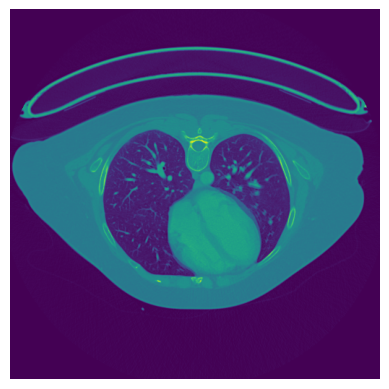

切片 0 的维度: (512, 512)
0.0


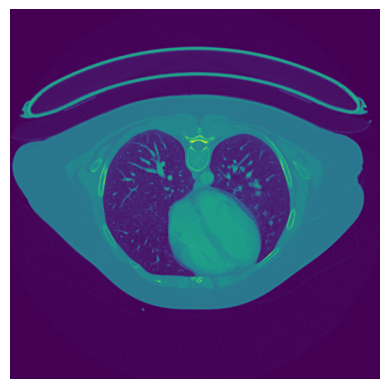

切片 1 的维度: (512, 512)
-1.0


In [36]:

# 2. 读取并排序 DICOM

slices = []
i=0
for f in dcm_files:
    try:
        ds = dicomio.dcmread(f)
        if i == 0:
            print('打印一个CT切片的DICOM信息:')
            print(ds)
            

        # 先转为 float 避免计算溢出
        image = ds.pixel_array.astype(np.float32)
        
        # 应用斜率和截距 (如果存在)
        if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
            if i == 0:
                print('应用斜率和截距')
            slope = float(ds.RescaleSlope)
            intercept = float(ds.RescaleIntercept)
            image = image * slope + intercept
            if i in (0,1):
                plt.imshow(image)
                plt.axis('off')  # 可选：不显示坐标轴
                plt.show()
                # 打印图片维度
                print(f"切片 {i} 的维度: {image.shape}")
                print(float(ds.ImagePositionPatient[2]))

        # slices.append(ds)
        slices.append((float(ds.ImagePositionPatient[2]), image))
    except Exception:
        pass
    i+=1


In [37]:

# 按 Z 轴位置排序
# slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
slices.sort(key=lambda x: x[0])
    

✅ [PatientPancreas-CT-Label\label0006.nii.gz 0006] NIfTI 读取成功
📊 数据信息:
   ▪ 形状: (512, 512, 223)
   ▪ 数据类型: float64
   ▪ 数值范围: [0.00, 1.00]
   ▪ 唯一标签: [0. 1.]


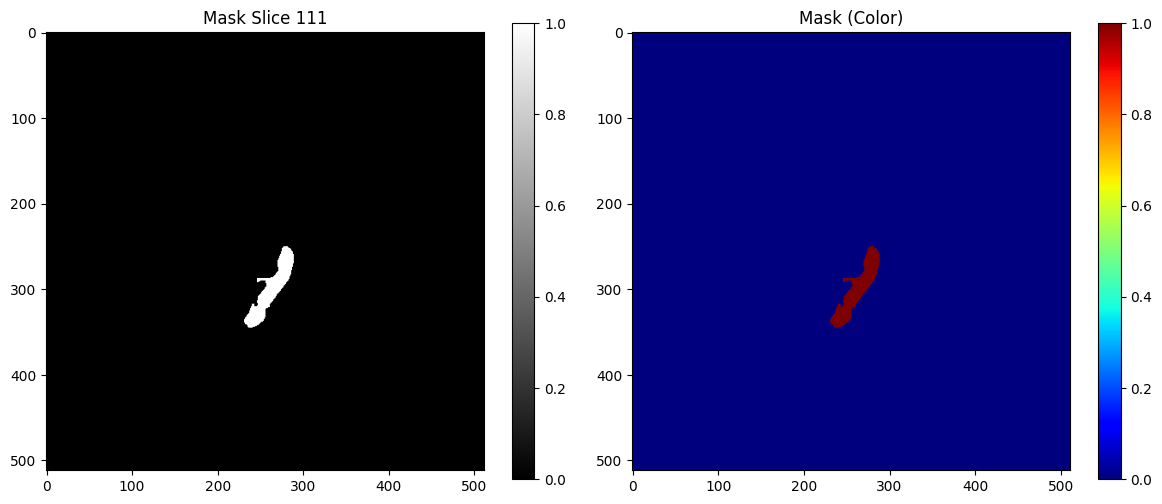

In [38]:
import matplotlib.pyplot as plt
import numpy as np

try:
    mask_obj = nib.load(nifti_path)
    mask_data = mask_obj.get_fdata()
    
    print(f"✅ [Patient{nifti_path} {patient_id}] NIfTI 读取成功")
    print(f"📊 数据信息:")
    print(f"   ▪ 形状: {mask_data.shape}")
    print(f"   ▪ 数据类型: {mask_data.dtype}")
    print(f"   ▪ 数值范围: [{mask_data.min():.2f}, {mask_data.max():.2f}]")
    print(f"   ▪ 唯一标签: {np.unique(mask_data)}")
    
    # 显示切片
    if len(mask_data.shape) == 3:
        mid_slice = mask_data.shape[2] // 2
        slice_data = mask_data[:, :, mid_slice]
        slice_data = mask_data[:, :, 100]
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(slice_data, cmap='gray')
        plt.title(f'Mask Slice {mid_slice}')
        plt.colorbar()
        
        plt.subplot(1, 2, 2)
        plt.imshow(slice_data, cmap='jet')
        plt.title('Mask (Color)')
        plt.colorbar()
        
        plt.tight_layout()
        plt.show()
        
    elif len(mask_data.shape) == 2:
        plt.figure(figsize=(8, 6))
        plt.imshow(mask_data, cmap='jet')
        plt.title('2D Mask')
        plt.colorbar()
        plt.show()
        
except Exception as e:
    print(f"❌ [Patient {patient_id}] NIfTI 读取失败: {e}")

In [43]:

# 4. 对齐层数
num_dcm = len(slices)
num_mask = mask_data.shape[2]
print(f"🔍 [Patient {patient_id}] DICOM 切片数: {num_dcm}, Mask 切片数: {num_mask}")
valid_slices = min(num_dcm, num_mask)
print(f"🔍 [Patient {patient_id}] 有效切片数: {valid_slices}")

if valid_slices < 10:
    pass


🔍 [Patient 0006] DICOM 切片数: 223, Mask 切片数: 223
🔍 [Patient 0006] 有效切片数: 223


In [42]:
    
# 5. 保存 PNG
save_dir_ct = os.path.join(CONFIG['processed_2d_dir'], 'Patient' + patient_id, 'CT')
save_dir_mask = os.path.join(CONFIG['processed_2d_dir'], 'Patient' + patient_id, 'Masks')
os.makedirs(save_dir_ct, exist_ok=True)
os.makedirs(save_dir_mask, exist_ok=True)

# ... (前面的代码保持不变)


In [47]:
try:
    for s in range(valid_slices):
        mask_slice = mask_data[:, :, s]
        
        # 获取原始 CT 数据
        # raw_ct_slice = slices[s].pixel_array.transpose(1, 0)
        raw_ct_slice = slices[s][1].transpose(1, 0)
        
        # --- 🔥 修改开始 🔥 ---
        # 1. 对 CT 进行窗位调整和归一化 (关键修复!)
        processed_ct_slice = process_ct_window(raw_ct_slice, w_level=40, w_width=400)
        
        # 2. 确保 Mask 也是 uint8 格式 (0 和 255, 或者 0 和 1)
        # 建议将 Mask 乘以 255 以便肉眼观察，但在读取时要除回来
        mask_slice = (mask_slice * 255).astype(np.uint8)
        # 保持 0/1 但转为 uint8
        # mask_slice = mask_slice.astype(np.uint8)
        # --- 🔥 修改结束 🔥 ---

        # --- 🛠️ 验证代码开始 🛠️ ---
        # 仅检查前 3 个病人，且仅当 Mask 有内容时才验证，防止生成太多图片
        if int(patient_id) < 83 and mask_slice.sum() > 0:
            import matplotlib.pyplot as plt
            
            # 创建一个临时验证文件夹
            debug_dir = './debug_alignment'
            os.makedirs(debug_dir, exist_ok=True)
            
            plt.figure(figsize=(10, 10))
            # 显示 CT 底图 (灰度)
            plt.imshow(processed_ct_slice, cmap='gray')
            # 叠加 Mask (红色，半透明 alpha=0.5)
            # np.ma.masked_where 用于隐藏 Mask 中为 0 的背景部分，只显示胰腺
            masked_label = np.ma.masked_where(mask_slice == 0, mask_slice)
            plt.imshow(masked_label, cmap='jet', alpha=0.5, interpolation='none')
            
            plt.title(f"Patient {patient_id} - Slice {s} - Alignment Check")
            # 保存图片
            plt.savefig(os.path.join(debug_dir, f"Check_P{patient_id}_S{s}.png"))
            plt.close()
            
            print(f"✅ 已保存验证图片到 {debug_dir}/Check_P{patient_id}_S{s}.png，请立即下载查看！")
            # --- 🛠️ 验证代码结束 🛠️ ---

        filename = f"{s:04d}.png"
        cv2.imwrite(os.path.join(save_dir_mask, filename), mask_slice)
        cv2.imwrite(os.path.join(save_dir_ct, filename), processed_ct_slice)
    
except Exception as e:
    print(f"❌ [Patient {patient_id}] 保存出错: {e}")      

print("--- 数据预处理完成 ---")

✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S85.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S86.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S87.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S88.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S89.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S90.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S91.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S92.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S93.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S94.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S95.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S96.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S97.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S98.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S99.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S100.png，请立即下载查看！
✅ 已保存验证图片到 ./debug_alignment/Check_P0006_S101.png，请立即下载查看！
✅ 已保存验证图片到 .

In [4]:
# 1. 执行预处理
preprocess_data_robust()

# 2. 构建数据索引
print("构建文件索引...")
patient_path_list = {'CT': {}, 'Masks': {}}
patient_image_cnt_CT = {}
patient_image_cnt_Mask = {}
valid_patients = []
patient_dirs = sorted(glob.glob(os.path.join(CONFIG['processed_2d_dir'], 'Patient*')))

for p_dir in patient_dirs:
    p_key = os.path.basename(p_dir)
    ct_files = sorted(glob.glob(os.path.join(p_dir, 'CT', '*.png')))
    mask_files = sorted(glob.glob(os.path.join(p_dir, 'Masks', '*.png')))
    if len(ct_files) > 0 and len(ct_files) == len(mask_files):
        patient_path_list['CT'][p_key] = ct_files
        patient_path_list['Masks'][p_key] = mask_files
        patient_image_cnt_CT[p_key] = len(ct_files)
        patient_image_cnt_Mask[p_key] = len(mask_files)
        valid_patients.append(p_key)

print(f"有效病例数: {len(valid_patients)}")

# 3. 3D 数据缓存
print("检查 3D 数据缓存...")
d1 = torch.linspace(-1, 1, 256)
d2 = torch.linspace(-1, 1, 256)
d3 = torch.linspace(-1, 1, 128)
meshx, meshy, meshz = torch.meshgrid((d1, d2, d3), indexing='ij')
grid = torch.stack((meshx, meshy, meshz), 3).unsqueeze(0)

new_pt_count = 0
for patient in valid_patients:
    out_ct_path = os.path.join(CONFIG['processed_3d_dir'], patient + '_CT.pt')
    if not os.path.exists(out_ct_path):
        try:
            volume_composer(patient, patient_image_cnt_CT, patient_path_list, grid)
            new_pt_count += 1
        except Exception as e:
            print(f"Resizing {patient} error: {e}")

if new_pt_count == 0:
    print("✅ 所有 3D 数据 (.pt) 已存在，跳过重采样步骤。")
else:
    print(f"🔄 新生成了 {new_pt_count} 个 3D 数据文件。")

--- 检查数据状态 ---
✅ 检测到本地已有预处理数据 (./data)，跳过 PNG 生成步骤。
构建文件索引...
有效病例数: 80
检查 3D 数据缓存...
✅ 所有 3D 数据 (.pt) 已存在，跳过重采样步骤。


In [5]:
# 4. 训练准备
print("准备 Dataset...")
part = partitioning(valid_patients, split_ratio=[0.7, 0.1, 0.2])

# 增加patch大小，可能需要调整学习率、数据增强尺寸、模型初始特征图数量
# kc, kh, kw = 32, 64, 64
# dc, dh, dw = 32, 64, 64
kc, kh, kw = 48, 96, 96  
dc, dh, dw = 48, 96, 96
# kc, kh, kw = 64, 128, 128  
# dc, dh, dw = 64, 128, 128


CT_patches = {}
mask_patches = {}

print("加载 Patches (这步需要一点内存)...")
for p in ['train', 'valid']:
    CT_patches[p], mask_patches[p] = patch_creator(part[p], kw, kh, kc, dw, dh, dc)

dataset_train = Pancreas_3D_dataset(CT_patches['train'], mask_patches['train'], augment=True, is_train=True)
dataset_valid = Pancreas_3D_dataset(CT_patches['valid'], mask_patches['valid'], augment=False, is_train=False)

loaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=CONFIG['batch_size'], 
                                         shuffle=True, num_workers=CONFIG['num_workers'],pin_memory=True),# 启用内存锁定，加速数据传输
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=CONFIG['batch_size'], 
                                         shuffle=False, num_workers=CONFIG['num_workers'],pin_memory=True)
}
print("DataLoader 准备就绪。")

准备 Dataset...
train:  56   valid:  7   test:  17   total:  80
加载 Patches (这步需要一点内存)...
Filtering patches... Original size: 448
Filtered size: 119
DataLoader 准备就绪。


--- 🔍 正在检查 DataLoader 输出 ---
📦 Batch Shape: Images=torch.Size([96, 1, 48, 96, 96]), Targets=torch.Size([96, 1, 48, 96, 96])
📊 Image Values: min=-0.0472, max=1.0394, mean=0.3537
🎯 Target Values: min=0.0000, max=1.0000
🔢 Target Unique Values (前10个): tensor([0, 1], dtype=torch.int32)


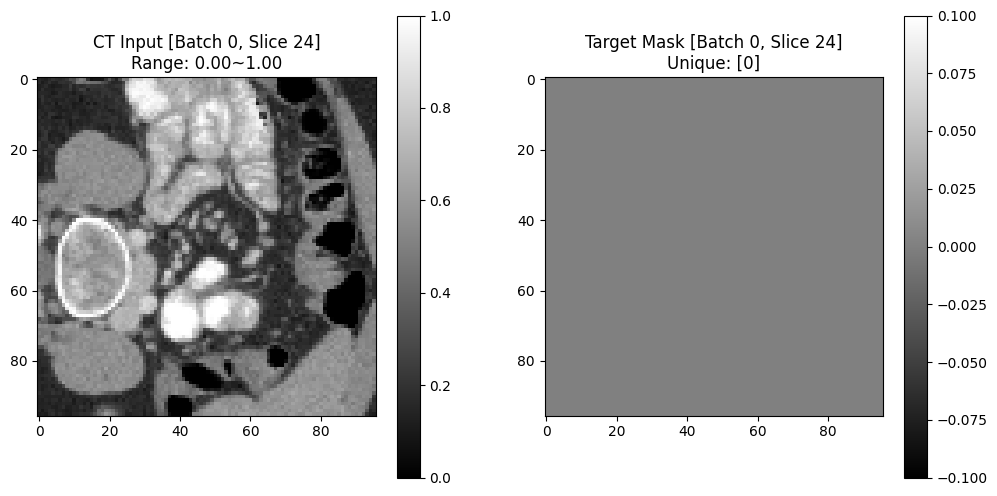

✅ 数据范围看起来正常。请检查上图：CT是否清晰？Mask是否有白色高亮区域？


In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np

print("--- 🔍 正在检查 DataLoader 输出 ---")

# 1. 从训练集 Loader 中取出一个 Batch
# iter() 创建迭代器，next() 获取第一组数据
try:
    data_iter = iter(loaders['train'])
    images, targets = next(data_iter)
except Exception as e:
    print(f"❌ DataLoader 读取失败: {e}")
    # 如果失败，可能是 num_workers 太大导致多进程报错，尝试设为 0 调试
    print("尝试将 CONFIG['num_workers'] 设为 0 再试。")
    raise e

# 2. 打印基础统计信息
print(f"📦 Batch Shape: Images={images.shape}, Targets={targets.shape}")
print(f"📊 Image Values: min={images.min():.4f}, max={images.max():.4f}, mean={images.mean():.4f}")
print(f"🎯 Target Values: min={targets.min():.4f}, max={targets.max():.4f}")
print(f"🔢 Target Unique Values (前10个): {torch.unique(targets)[:10]}")

# 3. 可视化检查 (取 Batch 中的第 0 个样本)
idx = 0 
# 获取 3D 数据的中间切片索引 (Depth / 2)
mid_slice = images.shape[2] // 2 

img_slice = images[idx, 0, mid_slice, :, :].numpy()
mask_slice = targets[idx, 0, mid_slice, :, :].numpy()

plt.figure(figsize=(12, 6))

# 左图：CT 原图
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.title(f"CT Input [Batch {idx}, Slice {mid_slice}]\nRange: {img_slice.min():.2f}~{img_slice.max():.2f}")
plt.colorbar()

# 右图：Mask 标签
plt.subplot(1, 2, 2)
plt.imshow(mask_slice, cmap='gray')
plt.title(f"Target Mask [Batch {idx}, Slice {mid_slice}]\nUnique: {np.unique(mask_slice)}")
plt.colorbar()

plt.show()

# 4. 关键逻辑判断
if targets.max() > 1.0:
    print("❌ 严重警告: Mask 值大于 1.0 (例如 255)！这会导致 Dice Loss 失效。")
    print("👉 请检查 volume_patch_composer 或 Dataset 中的归一化除法。")
elif targets.sum() == 0:
    print("⚠️ 警告: 这个 Batch 里似乎全是背景 (Mask 全黑)。")
    print("👉 如果这种情况频繁出现，说明你的采样策略 (15% 背景保留) 可能没生效，或者 Patch 太小切不到胰腺。")
else:
    print("✅ 数据范围看起来正常。请检查上图：CT是否清晰？Mask是否有白色高亮区域？")

In [7]:
# 5. 初始化模型与优化器
print("初始化模型...")
model = UNet_3D(1, 1, 32, 0.3)

# ================= 关键修改：加载预训练模型 =================
# ⚠️ 注意：请确认文件名是否正确
checkpoint_path = 'results/run_20251130-0316_model.pt' 

if os.path.exists(checkpoint_path):
    print(f"🔄 正在加载预训练模型: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
    print("✅ 加载成功！将在现有基础上继续训练。")
else:
    print("⚠️ 未找到预训练模型，将从头开始训练。")     
# ========================================================

if CONFIG['train_on_gpu']:
    # 1. 先把模型搬到主 GPU (cuda:0)
    model.cuda()
    
    # 2. 再进行多卡包装
    if torch.cuda.device_count() > 1:
        print(f"🚀 检测到 {torch.cuda.device_count()} 个 GPU，已启用多卡并行训练 (DataParallel)!")
        # 使用 DataParallel 包装模型
        model = torch.nn.DataParallel(model)       

# ✅ 使用新的混合 Loss
# alpha=0.7 强调召回，bce_weight=0.5 提供梯度平滑
# criterion = MixedLoss(alpha=0.7, beta=0.3, bce_weight=0.8, pos_weight=10)
# if CONFIG['train_on_gpu']:
#         criterion.cuda()

# 纯 BCE：估算一个权重，比如前景只占 5%，那么权重设为 20 左右；
# 对于胰腺分割，通常设 10.0 到 50.0 之间。你可以先试 10.0。
# 如果 train_on_gpu 为 True，必须把权重也移到 GPU
# pos_weight = torch.tensor([15.0])
# if torch.cuda.is_available():
#     pos_weight = pos_weight.cuda()
# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 定义 Loss (这里用了你新的参数)
criterion = TverskyLoss(1e-6, 0.7, 0.3)

# 1. 定义基础优化器 (LR 会被 Scheduler 覆盖，所以这里初始 LR 可以随意，但建议设为 max_lr 的 1/10 或 1/25)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # 在优化器中增加权重衰减

# 2.定义 OneCycleLR
# max_lr: 最大学习率，可以尝试 1e-3 或 5e-4
# steps_per_epoch: 每个 epoch 的 batch 数量
# epochs: 总 epoch 数
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, 
#     max_lr=5e-4, 
#     steps_per_epoch=len(loaders['train']), 
#     epochs=CONFIG['n_epochs']
# )

# 余弦退火热身重启
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, 
#     T_0=20,           # 初始周期长度
#     T_mult=2,         # 周期倍增因子
#     eta_min=1e-6
# )

#当指标进入平原期（不再变化）时，降低学习率。
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # 监控指标是越小越好 (Loss)
    factor=0.5,      # 每次降低一半 (0.1 也可以)
    patience=10,     # 容忍 10 个 Epoch 不下降
)

print("模型初始化完成。")

初始化模型...
🔄 正在加载预训练模型: results/run_20251130-0316_model.pt
✅ 加载成功！将在现有基础上继续训练。
🚀 检测到 4 个 GPU，已启用多卡并行训练 (DataParallel)!
模型初始化完成。


In [ ]:
# 设置保存路径
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
timestamp = time.strftime("%Y%m%d-%H%M")
experiment_name = f"run_{timestamp}"
model_save_path = os.path.join(results_dir, f"{experiment_name}_model.pt")
loss_plot_path = os.path.join(results_dir, f"{experiment_name}_loss_curve.png")
metric_save_path = os.path.join(results_dir, f"{experiment_name}_metrics.csv")
test_save_path = os.path.join(results_dir, f"{experiment_name}_inference_results.csv")

print(f"🚀 开始训练: {experiment_name}")

if not CONFIG['inference_only']:
    # 3. 把 scheduler 传进去
    model = train_3D(CONFIG['n_epochs'], loaders, model, optimizer, criterion, 
                     CONFIG['train_on_gpu'], performance_metrics, model_save_path,metric_save_path, 0.5, 
                     scheduler=scheduler) # 传入 scheduler
    
    # 训练结束后处理数据
    if os.path.exists(metric_save_path):
        df = pd.read_csv(metric_save_path)
        
        # 直接在 Jupyter 中画图
        plt.figure(figsize=(10, 5))
        plt.plot(df['epoch'], df['Training Loss'], label='Train')
        plt.plot(df['epoch'], df['Validation Loss'], label='Valid')
        plt.legend()
        plt.title(f'Training Process ({experiment_name})')
        
        plt.savefig(loss_plot_path)
        plt.show() # 保存后再显示        
        
        print("训练完成。")

🚀 开始训练: run_20251130-1851


  0%|          | 0/101 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


  1%|          | 1/101 [00:48<1:20:03, 48.04s/it]

Epoch: 1 	Training Loss: 0.6173 	Validation Loss: 0.5211 	LR: 0.000100
Specificity: 0.996260 	Sensitivity: 0.542655 	Precision: 0.377454 	F2_score: 0.498977 	DSC: 0.445224
Validation DSC increased.  Saving model ...
=== Epoch #2 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


  2%|▏         | 2/101 [01:05<49:46, 30.17s/it]  

Epoch: 2 	Training Loss: 0.6662 	Validation Loss: 0.5298 	LR: 0.000100
Specificity: 0.996600 	Sensitivity: 0.518703 	Precision: 0.389334 	F2_score: 0.486380 	DSC: 0.444803
=== Epoch #3 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


  3%|▎         | 3/101 [01:23<40:00, 24.50s/it]

Epoch: 3 	Training Loss: 0.5953 	Validation Loss: 0.5382 	LR: 0.000100
Specificity: 0.996819 	Sensitivity: 0.499253 	Precision: 0.396074 	F2_score: 0.474529 	DSC: 0.441718
=== Epoch #4 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


  4%|▍         | 4/101 [01:41<35:17, 21.83s/it]

Epoch: 4 	Training Loss: 0.5933 	Validation Loss: 0.5455 	LR: 0.000100
Specificity: 0.996952 	Sensitivity: 0.485216 	Precision: 0.399479 	F2_score: 0.465246 	DSC: 0.438193
=== Epoch #5 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


  5%|▍         | 5/101 [01:58<32:34, 20.36s/it]

Epoch: 5 	Training Loss: 0.6283 	Validation Loss: 0.5473 	LR: 0.000100
Specificity: 0.996952 	Sensitivity: 0.483082 	Precision: 0.398432 	F2_score: 0.463392 	DSC: 0.436692
=== Epoch #6 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


  6%|▌         | 6/101 [02:16<30:51, 19.49s/it]

Epoch: 6 	Training Loss: 0.5573 	Validation Loss: 0.5451 	LR: 0.000100
Specificity: 0.996788 	Sensitivity: 0.492162 	Precision: 0.390343 	F2_score: 0.467759 	DSC: 0.435378
=== Epoch #7 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


  7%|▋         | 7/101 [02:34<29:34, 18.87s/it]

Epoch: 7 	Training Loss: 0.5652 	Validation Loss: 0.5562 	LR: 0.000100
Specificity: 0.997120 	Sensitivity: 0.466920 	Precision: 0.403866 	F2_score: 0.452782 	DSC: 0.433110
=== Epoch #8 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


  8%|▊         | 8/101 [02:52<28:41, 18.51s/it]

Epoch: 8 	Training Loss: 0.6298 	Validation Loss: 0.5654 	LR: 0.000100
Specificity: 0.997320 	Sensitivity: 0.448217 	Precision: 0.411360 	F2_score: 0.440327 	DSC: 0.428999
=== Epoch #9 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


  9%|▉         | 9/101 [03:09<27:58, 18.25s/it]

Epoch: 9 	Training Loss: 0.5750 	Validation Loss: 0.5682 	LR: 0.000100
Specificity: 0.997348 	Sensitivity: 0.444017 	Precision: 0.411602 	F2_score: 0.437132 	DSC: 0.427195
=== Epoch #10 ===
=== Training ===

DEBUG: Data Shape: torch.Size([96, 1, 48, 96, 96])
DEBUG: Target Shape: torch.Size([96, 1, 48, 96, 96])

DEBUG: Target Max Value: 1.0
✅ Mask 值正常 (0-1)。
1 / 2...
=== Validation ===
1 / 1...


 10%|▉         | 10/101 [03:27<27:34, 18.18s/it]

Epoch: 10 	Training Loss: 0.5637 	Validation Loss: 0.5544 	LR: 0.000100
Specificity: 0.997003 	Sensitivity: 0.472789 	Precision: 0.397260 	F2_score: 0.455470 	DSC: 0.431746
=== Epoch #11 ===
=== Training ===


In [ ]:
print("\n--- 开始测试集评估 ---")
# 加载刚刚训练好的模型（或者你可以手动指定其他路径）
best_model_path = model_save_path
# best_model_path = 'results/run_20251129-1415_model.pt'

if os.path.exists(best_model_path):
    print(f"加载模型权重: {best_model_path}...")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    
    print(f"正在测试 {len(part['test'])} 个测试集病例...")
    df_test = get_inference_performance_metrics_3D(model, part['test'], Pancreas_3D_dataset, 
                                                  CONFIG['batch_size'], CONFIG['train_on_gpu'], 
                                                  0.5, kw, kh, kc, dw, dh, dc)
    print("\n📊 测试集结果统计:")
    display(df_test.describe()) # Jupyter 特有的漂亮表格显示
    
    df_test.to_csv(test_save_path, index=False)
    print(f"✅ 详细测试结果已保存至: {test_save_path}")
    # 添加统计信息到同一个文件（追加模式）
    with open(test_save_path, 'a') as f:
        f.write('\n')  # 空行分隔
        f.write('# Statistical Summary\n')
        df_test.describe().to_csv(f, header=True)
else:
    print("未找到模型文件。")

In [ ]:
from inference import visualize_patient_prediction_3D

i=4
visualize_patient_prediction_3D(
    model=model, 
    patient=part['train'][i], # 可视化测试
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=1, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)
visualize_patient_prediction_3D(
    model=model, 
    patient=part['valid'][i], # 可视化测试
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=1, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)
visualize_patient_prediction_3D(
    model=model, 
    patient=part['test'][i], # 可视化测试
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=1, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)

In [ ]:
# 训练结束后自动关机
# !shutdown